Logging into HF hub

In [1]:
import os

from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from .env file
load_dotenv()

# Access the Hugging Face Hub API token
huggingfacehub_api_token = os.getenv('HUGGINGFACEHUB_API_TOKEN')

# Log in to the Hugging Face Hub
login(token=huggingfacehub_api_token)

Loading tech4humans signature dataset

In [2]:
from datasets import load_dataset

# Load the tech4humans signature dataset
dataset = load_dataset("samuellimabraz/signature-detection")

# Print the dataset to verify it has been loaded correctly
print(dataset["train"][0])

{'image_id': 1825, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x1F664D51130>, 'width': 640, 'height': 640, 'objects': {'id': [2134, 2135, 2136, 2137], 'area': [5081, 1064, 4626, 1503], 'bbox': [[198.0, 55.0, 43.060001373291016, 118.0], [263.0, 195.0, 24.750999450683594, 43.0], [518.0, 37.0, 46.72800064086914, 99.0], [587.0, 157.0, 28.908000946044922, 52.0]], 'category': [0, 0, 0, 0]}}


Converting it to CocoDataset

In [50]:
import os
import json
from PIL import Image
from tqdm import tqdm


def convert_to_coco(dataset, output_dir, split_name, save_images=False, image_dir=None):
    os.makedirs(output_dir, exist_ok=True)
    if save_images:
        image_dir = image_dir or os.path.join(output_dir, "images", split_name)
        os.makedirs(image_dir, exist_ok=True)

    images = []
    annotations = []
    categories = [{"id": 0, "name": "signature"}]
    ann_id = 1  # global annotation ID counter

    for idx, example in tqdm(enumerate(dataset), total=len(dataset), desc=f"Processing {split_name}"):
        image_id = example["image_id"]
        width = example["width"]
        height = example["height"]
        file_name = f"{image_id}.jpg"

        if save_images:
            image_path = os.path.join(image_dir, file_name)
            example["image"].save(image_path)

        images.append({
            "id": image_id,
            "file_name": file_name,
            "width": width,
            "height": height,
        })

        objects = example["objects"]
        for i in range(len(objects["id"])):
            annotations.append({
                "id": ann_id,
                "image_id": image_id,
                "category_id": objects["category"][i],
                "bbox": objects["bbox"][i],
                "area": objects["area"][i],
                "iscrowd": 0,
            })
            ann_id += 1

    coco_dict = {
        "images": images,
        "annotations": annotations,
        "categories": categories,
        "info": {
            "description": "Signature Dataset",
            "version": "1.0",
            "year": 2025,
            "contributor": "",
            "date_created": "",
        },
        "licenses": [{"id": 1, "name": "Unknown", "url": ""}],
    }

    json_path = os.path.join(output_dir, f"{split_name}.json")
    with open(json_path, "w") as f:
        json.dump(coco_dict, f)


In [51]:
output_dir = "datasets"

convert_to_coco(dataset["train"], output_dir, "train", save_images=True)
convert_to_coco(dataset["validation"], output_dir, "val", save_images=True)
convert_to_coco(dataset["test"], output_dir, "test", save_images=True)


Processing test: 100%|██████████| 419/419 [00:01<00:00, 249.65it/s]


In [52]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, processor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        annotations = {'image_id': self.ids[idx], 'annotations': annotations}
        encoding = self.processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [53]:
train_dataset = CocoDetection(img_folder='datasets/images/train', ann_file="datasets/train.json", processor=processor)
val_dataset = CocoDetection(img_folder='datasets/images/val', ann_file="datasets/val.json", processor=processor)
test_dataset = CocoDetection(img_folder='datasets/images/test', ann_file="datasets/test.json", processor=processor)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Loading pre-trained model

In [7]:
from transformers import YolosImageProcessor, YolosForObjectDetection

CKPT_PATH = "hustvl/yolos-small"
IMG_SIZE = 640
TARGET = "signature"
ID2LABEL = {0: TARGET}
LABEL2ID = {TARGET: 0}

processor = YolosImageProcessor.from_pretrained(CKPT_PATH, do_resize=True, size={"width": IMG_SIZE, "height": IMG_SIZE})
model = YolosForObjectDetection.from_pretrained(CKPT_PATH, num_labels=len(ID2LABEL), id2label=ID2LABEL, label2id=LABEL2ID, ignore_mismatched_sizes=True, device_map="auto")

c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\accelerate\utils\modeling.py:808: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  _ = torch.tensor([0], device=i)
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Converting data into COCO format

In [ ]:
# from utils.dataset import SignatureDataset

# train_dataset = SignatureDataset(dataset["train"], processor)
# val_dataset = SignatureDataset(dataset["validation"], processor)
# test_dataset = SignatureDataset(dataset["test"], processor)

creating index...
index created!
creating index...
index created!
creating index...
index created!


In [54]:
from torch.utils.data import DataLoader
from utils.dataset import get_collate_fn

collate_fn = get_collate_fn(processor)

BATCH_SIZE = 1

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)
batch = next(iter(train_dataloader))

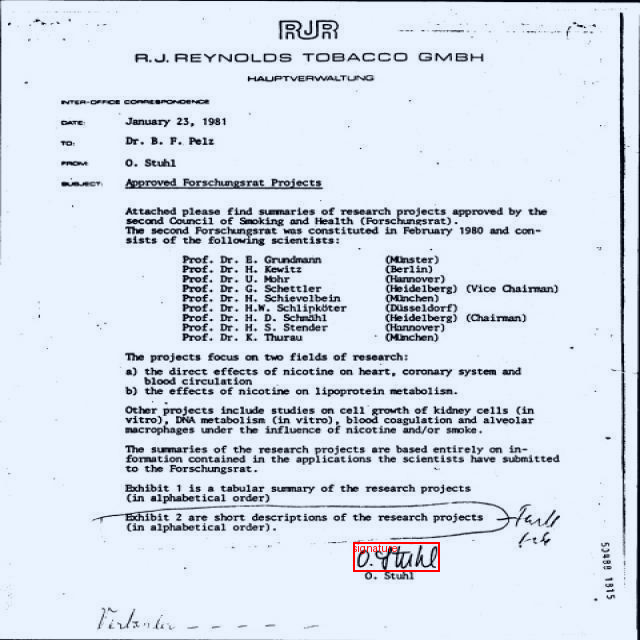

In [55]:
from utils.visualizer import visualize_item

visualize_item(test_dataset[0])

Fine-tuning the model

In [41]:
from utils.model import YolosForSignatureDetection

pl_model = YolosForSignatureDetection(lr=2.5e-5, weight_decay=1e-4, model=yolos.model)

# outputs = pl_model(pixel_values=batch["pixel_values"].to(model.device))
# outputs.logits.shape

In [9]:
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=2000, gradient_clip_val=0.1, accumulate_grad_batches=4)
trainer.fit(pl_model)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `n

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Evaluating model

In [8]:
batch = next(iter(test_dataloader))

In [56]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
import torch
import time
import numpy as np
TEST_DATASET = test_dataset
TEST_DATALOADER = test_dataloader
DEVICE = yolos.model.device

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])
times = []
print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    tic = time.time()
    with torch.no_grad():
      outputs = yolos.model(pixel_values=pixel_values)
    times.append(time.time() - tic)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = yolos.image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/419 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.46s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.859
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.628
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.618
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [58]:
print(f"Average inference time: {np.mean(times):.4f} seconds")

Average inference time: 0.0113 seconds


In [42]:
import torch
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

# Initialize the COCO evaluator with ground truths
coco_evaluator = CocoEvaluator(coco_gt=test_dataset.coco, iou_types=["bbox"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pl_model.model.to(device)
pl_model.model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(test_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
        outputs = pl_model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results =  processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0.7) # convert outputs of model to COCO api

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    coco_evaluator.update(predictions)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


  0%|          | 0/419 [00:00<?, ?it/s]

KeyError: 'annotations'

In [27]:
res

{0: {'scores': tensor([1.4878e-04, 1.1568e-03, 6.1508e-03, 2.0732e-03, 2.9591e-03, 2.0804e-03,
          2.6787e-04, 1.3712e-02, 2.5635e-04, 1.3519e-04, 4.6555e-04, 2.8351e-04,
          7.7601e-04, 7.1848e-01, 9.4381e-04, 1.9654e-04, 2.4822e-03, 2.2695e-03,
          7.7496e-04, 2.2608e-03, 1.9689e-04, 5.7904e-03, 2.0730e-03, 1.7513e-03,
          5.1720e-03, 3.2260e-04, 1.2341e-04, 3.7421e-05, 3.7648e-05, 2.3464e-03,
          3.1542e-03, 5.1743e-04, 3.2314e-03, 2.5682e-03, 5.2978e-05, 8.7216e-04,
          2.9182e-03, 9.4888e-05, 1.3691e-03, 1.9979e-05, 5.3163e-04, 1.6147e-03,
          1.4207e-02, 1.2882e-02, 2.9186e-03, 1.6142e-03, 2.4841e-03, 2.9313e-03,
          5.0178e-03, 6.3544e-05, 1.0896e-03, 1.3317e-03, 9.4491e-04, 1.3243e-03,
          5.0697e-03, 7.4606e-04, 2.3784e-03, 2.0108e-03, 3.8558e-04, 3.4472e-03,
          7.2452e-04, 5.1478e-04, 2.3343e-03, 6.0342e-04, 3.6937e-03, 2.3189e-03,
          9.5613e-01, 1.7576e-03, 1.2896e-03, 4.0913e-04, 3.6183e-04, 3.1735e-04,
   

In [8]:
import torch

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [12]:
test_dataset.coco[0]

TypeError: 'COCO' object is not subscriptable

In [11]:
import torch
import time
from tqdm.notebook import tqdm
from coco_eval import CocoEvaluator

evaluator = CocoEvaluator(coco_gt=test_dataset.coco, iou_types=["bbox"])
DEVICE = pl_model.model.device
times = []
print("Running evaluation...")

for idx, batch in enumerate(tqdm(test_dataloader)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    tic = time.time()
    with torch.no_grad():
      outputs = pl_model.model(pixel_values=pixel_values)
    times.append(time.time() - tic)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0.7)

    # predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    # predictions = prepare_for_coco_detection(predictions)

     # Reformat predictions to COCO format
    coco_predictions = []
    for target, output in zip(labels, results):
        image_id = target["image_id"].item()
        boxes = output["boxes"]
        scores = output["scores"]
        labels_ = output["labels"]

        for box, score, label in zip(boxes, scores, labels_):
            x1, y1, x2, y2 = box.tolist()
            coco_predictions.append({
                "image_id": image_id,
                "category_id": int(label),
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "score": float(score)
            })
            
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/419 [00:00<?, ?it/s]

KeyError: 'annotations'

In [10]:
predictions

[]

In [29]:
predictions

[{'image_id': 329,
  'category_id': 0,
  'bbox': [27.66071319580078,
   391.22015380859375,
   221.11618041992188,
   44.493896484375],
  'score': 0.9955868721008301}]

Saving fine-tuned model to the Hub

In [ ]:
hf_model_name = CKPT_PATH.split("/")[-1] + "-signature-detection"
print("model saved at:", hf_model_name)

# saving model locally
# pl_model.model.save_pretrained(hf_model_name)
# processor.save_pretrained(hf_model_name)

# saving model to the Hub
# pl_model.model.push_to_hub(hf_model_name)
# processor.push_to_hub(hf_model_name)


model saved at: yolos-small-signature-detection


In [7]:
batch = next(iter(test_dataloader))

In [8]:
batch

{'pixel_values': tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.1975,  2.1804,  2.2147],
           [ 2.2147,  2.2147,  2.2147,  ...,  2.1804,  2.1804,  2.1975],
           [ 2.2147,  2.2147,  2.2147,  ...,  2.2318,  2.2318,  2.2147],
           ...,
           [ 2.2318,  2.2318,  2.2318,  ...,  2.2489,  0.8618, -1.6213],
           [ 2.2318,  2.2318,  2.2318,  ...,  2.0605,  0.9817, -1.2445],
           [ 2.2318,  2.2318,  2.2318,  ...,  1.1529,  0.3823, -1.5357]],
 
          [[ 2.4286,  2.4286,  2.4286,  ...,  2.3761,  2.3585,  2.3936],
           [ 2.3936,  2.3936,  2.3936,  ...,  2.3585,  2.3585,  2.3761],
           [ 2.3936,  2.3936,  2.3936,  ...,  2.4111,  2.4111,  2.3936],
           ...,
           [ 2.4111,  2.4111,  2.4111,  ...,  2.4286,  1.0105, -1.5280],
           [ 2.4111,  2.4111,  2.4111,  ...,  2.2360,  1.1331, -1.1429],
           [ 2.4111,  2.4111,  2.4111,  ...,  1.3081,  0.5203, -1.4405]],
 
          [[ 2.6400,  2.6400,  2.6400,  ...,  2.5877,  2.5703,  2.6051

# Inference example

In [17]:
from transformers import pipeline

yolos = pipeline(
    task="object-detection",
    model="mdefrance/yolos-small-signature-detection",
    device_map="auto"
)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [72]:
# applying inference on images of the test set
predictions = yolos([item.get("image") for item in dataset["test"]], batch_size=4)

Visualizing prediction and input

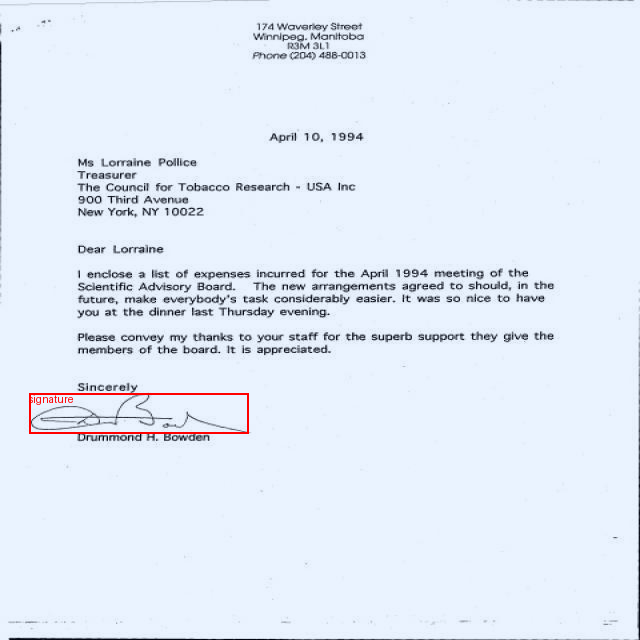

In [90]:
visualize_item(test_dataset[0])

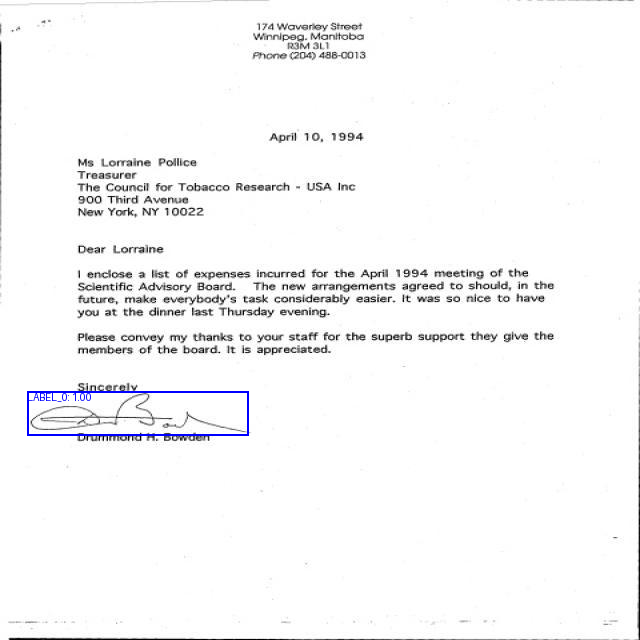

In [91]:
from utils.visualizer import visualize_prediction

visualize_prediction(dataset["test"][0].get("image"), predictions[0])

In [74]:
predictions[0]

[{'score': 0.9955868721008301,
  'label': 'LABEL_0',
  'box': {'xmin': 27, 'ymin': 391, 'xmax': 248, 'ymax': 435}}]

In [67]:
from tqdm.notebook import tqdm

outputs = []
for eval_batch in tqdm(test_dataloader, total=len(test_dataloader) / BATCH_SIZE):
    output = yolos(convert_tensor_to_pil_image(eval_batch["pixel_values"][0]))
    outputs += output


  0%|          | 0/419.0 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


KeyboardInterrupt: 